# Exploratory data analysis

In this notebook we explore the dataset provided by Emyr. It has the following characteristics:
  - 1k events
  - $t\bar t$ inclusive
  - branches of interest: 'scPuppiCorrJets'
  - one branch per variable per constituent

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import h5py
import uproot
import seaborn as sns

In [2]:
datadir  = '../data/TTbar/'
filename = 'perfNano_scPuppiCorrJets_nConst64.h5'
data     = pd.read_hdf(datadir+filename, key='data')
geninfo  = pd.read_hdf(datadir+filename, key='geninfo')

`data` contains data from the reconstructed jets with puppi (PileUp Per Particle Identification) algorithm reduction applied.  
There are 64 constituents for each jet, each one equipped with `pt, eta, phi, vz` and `pdgId`.
Information on `pt, eta, phi` of the jet are also given.  
Minimum 3 jets per event, maximum 16

In [4]:
data

pt       eta       phi  dau0_eta  dau0_pdgId  dau0_phi  \
entry subentry                                                              
0     0         86.25 -0.806874 -2.840166 -0.693768       211.0 -2.905973   
      1         80.50 -2.185923  1.125942 -2.199115       211.0  1.042834   
      2         63.00 -0.397301 -2.369233 -0.392699       130.0 -2.404191   
      3         60.75  1.928214  0.558369  1.911136       211.0  0.484329   
      4         60.00  0.048320 -2.124563  0.030543       211.0 -2.103122   
...               ...       ...       ...       ...         ...       ...   
999   11        17.00  1.889097 -0.780796  1.889319      -211.0 -0.781035   
      12        12.75  1.596874 -1.108301  1.596976       211.0 -1.108284   
      13        11.75 -1.514039  0.584447 -1.514073       211.0  0.584685   
      14        11.75 -0.021476  0.497777 -0.021817       211.0  0.497419   
      15        11.75 -1.745670 -2.242680 -1.745329       211.0 -2.242748   

                dau0_pt  dau0_vz  dau10_eta  dau10_pdgId  ...  dau8_eta  \
entry subentry                                            ...             
0     0            2.50    -1.25  -1.000000         -1.0  ... -0.859575   
      1           11.75    -0.60  -2.247111        211.0  ... -2.146755   
      2           23.50     0.00  -1.000000         -1.0  ... -1.000000   
      3            3.75    -1.40  -1.000000         -1.0  ... -1.000000   
      4           15.25    -1.15  -1.000000         -1.0  ...  0.061087   
...                 ...      ...        ...          ...  ...       ...   
999   11           5.00     0.35  -1.000000         -1.0  ... -1.000000   
      12           3.25     0.60  -1.000000         -1.0  ... -1.000000   
      13           3.00     1.35  -1.000000         -1.0  ... -1.000000   
      14           3.00     1.15  -1.000000         -1.0  ... -1.000000   
      15           3.00     0.40  -1.000000         -1.0  ... -1.000000   

                dau8_pdgId  dau8_phi  dau8_pt  dau8_vz  dau9_eta  dau9_pdgId  \
entry subentry                                                                 
0     0             -211.0 -2.748893     5.50    -1.05 -0.846485        22.0   
      1             -211.0  0.986111     4.25    -1.00 -2.225295       211.0   
      2               -1.0 -1.000000    -1.00    -1.00 -1.000000        -1.0   
      3               -1.0 -1.000000    -1.00    -1.00 -1.000000        -1.0   
      4               22.0 -2.382375     1.00     0.00 -1.000000        -1.0   
...                    ...       ...      ...      ...       ...         ...   
999   11              -1.0 -1.000000    -1.00    -1.00 -1.000000        -1.0   
      12              -1.0 -1.000000    -1.00    -1.00 -1.000000        -1.0   
      13              -1.0 -1.000000    -1.00    -1.00 -1.000000        -1.0   
      14              -1.0 -1.000000    -1.00    -1.00 -1.000000        -1.0   
      15              -1.0 -1.000000    -1.00    -1.00 -1.000000        -1.0   

                dau9_phi  dau9_pt  dau9_vz  
entry subentry                              
0     0        -2.696534      2.0     0.00  
      1         1.261000      4.0    -0.45  
      2        -1.000000     -1.0    -1.00  
      3        -1.000000     -1.0    -1.00  
      4        -1.000000     -1.0    -1.00  
...                  ...      ...      ...  
999   11       -1.000000     -1.0    -1.00  
      12       -1.000000     -1.0    -1.00  
      13       -1.000000     -1.0    -1.00  
      14       -1.000000     -1.0    -1.00  
      15       -1.000000     -1.0    -1.00  

[15052 rows x 323 columns]

In [5]:
njets = data.index.droplevel(1).value_counts()

print('max n_jets:', njets.max(), 'min n_jets:', njets.min())

max n_jets: 16 min n_jets: 3


`geninfo` contains the matching information, which is, each jet is matched with the MC ground truth.  

In order to match `scPuppiCorrJets` and MC ground truth, the following branches from the NanoAOD are considered:
  - `GenCands` (`genparts` in the script) has basic info (`'pt', 'eta', 'phi', 'mass'`) plus `'pdgId', 'charge','status'`;  
  - `GenJets` (`genjets` in the script) has basic info plus `'hadronFlavour', 'partonFlavour'` and a `dau*` branch for each constituent.

The matching follows two steps:
  1. `scPuppiCorrJets` are matched with `genparts` to calculate $\Delta R$ w.r.t different particles (g, q, b, t, W, e, mu, tau) &rarr; we get the particle type of jet?
  2. `scPuppiCorrJets` are matched with `genjets` to calculate $\Delta R$ and get from `genjets` the hadron and parton flavours (based on minimum $\Delta R$) N.B.: we have more `scPuppiCorrJets` than `genjets`

Could it be that Generators generate particles (genparts) and then these particles are grouped into jets of 64 constituents (genjets)? So we have many more partciles in genparts than in the total genjets. Then a reconstruction algorithm is run and we can compare genjets vs recojests?  
Otherwise a Generator generates particles (millions), then another one generates jets coming from these particles. Thus, it makes sense to compare recojets to getparts to see which particle originated them. But why #genparts >> #genjets? maybe truncation?  
Otherwise it is the first option but some generate particles are vertices, others are jet constituents, so they are grouped in genjets and then we compare genparts with recojets to see which particle is at vertex


__Warning: Matching in Dense Environments__ (from CMS WorkBook)  
Matching by $\Delta R$ may not work reliably in dense environments, such as jets. For studies needing high quality matching of reconstructed tracks with true tracks, it is possible to base the matching either on the number of hits that they share in common, or on a comparison of the 5 helix parameters describing the track. How to do this is described here, but unfortunately can only be done on FEVT data, since it requires the presence of TrackingParticles that are not stored on RECO. (These are truth tracks, which contain links to the GEANT-produced SimTracks and generator-produced GenParticles that they correspond to).




In [6]:
geninfo

min_dR_g  min_dR_q  min_dR_b  min_dR_t  min_dR_W  \
entry subentry subsubentry                                                     
0     0        0            0.122271  0.889654  0.406528  0.572287  1.097422   
      1        0            0.024429  0.028047  2.338617  1.363257  0.464453   
      2        0            0.045876  0.273854  1.021109  0.252343  0.486100   
      3        0            0.012256  2.721996  4.068618  3.836369  3.271721   
      4        0            0.051471  0.235471  1.519467  0.706747  0.322576   
...                              ...       ...       ...       ...       ...   
999   11       0            0.290617  0.582188  0.722488  1.131079  1.991264   
      12       0            0.231795  0.459720  0.435267  1.535691  2.066015   
      13       0            0.205056  3.184344  3.541165  4.496080  3.772168   
      14       0            0.711415  2.327705  2.066416  3.020956  2.788016   
      15       0            0.226147  3.033555  3.271312  3.754769  3.494336   

                            min_dR_e  min_dR_mu  min_dR_tau  min_dR_genjet  \
entry subentry subsubentry                                                   
0     0        0            1.699532        NaN         NaN       0.028681   
      1        0            2.581017        NaN         NaN       0.028385   
      2        0            1.318046        NaN         NaN       0.033363   
      3        0            3.209387        NaN         NaN       0.021991   
      4        0            1.350567        NaN         NaN       0.010595   
...                              ...        ...         ...            ...   
999   11       0                 NaN        NaN    1.245959       0.725950   
      12       0                 NaN        NaN    0.809127       0.546838   
      13       0                 NaN        NaN    3.546099       2.525770   
      14       0                 NaN        NaN    2.548183       2.005163   
      15       0                 NaN        NaN    2.918918       0.752949   

                            partonFlavour  hadronFlavour  
entry subentry subsubentry                                
0     0        0                        5              5  
      1        0                       -4              4  
      2        0                        2              0  
      3        0                       21              0  
      4        0                        2              0  
...                                   ...            ...  
999   11       0                       -5              5  
      12       0                        5              5  
      13       0                       21              0  
      14       0                       21              0  
      15       0                       21              0  

[15052 rows x 11 columns]

In [7]:
print('hadron flavours:', geninfo['hadronFlavour'].unique(), '\nparton flavours:', geninfo['partonFlavour'].unique())

hadron flavours: [5 4 0] 
parton flavours: [ 5 -4  2 21  3 -1  4 -5  1 -3 -2  0]


|type   |id |meaning        |
|-------|---|-----------    |
|hadron |5  |b jet (ghost b)|
|       |4  |c jet (ghost c, no b)|
|       |0  | light jet |
|parton |5  |b jet (ghost b)|
|       |4  |c jet (same)   |
|       |0  |undefined      |
|       |1 ecc  |light ()   |

Let's remember some properties of particles:  
<img src="https://upload.wikimedia.org/wikipedia/commons/4/40/Modello_Standard_delle_Particelle_Elementari.svg"  width="40%" style="background-color:lightgrey;">

In [3]:
def display_statistics(data, ax, fontsize=16, align="left", x=0.05, y=0.95, step=0.05):
    
    xmin   = np.min(data)
    xmax   = np.max(data)
    mean   = np.mean(data)
    std    = np.std(data)
    median = np.median(data)
    mode   = data.mode()[0]
    
    ax.text(x, y-0*step, f"Minimum: {xmin:.2f}",  fontsize=fontsize, transform=ax.transAxes, ha=align)
    ax.text(x, y-1*step, f"Maximum: {xmax:.2f}",  fontsize=fontsize, transform=ax.transAxes, ha=align)
    ax.text(x, y-2*step, f"Mean: {mean:.2f}",     fontsize=fontsize, transform=ax.transAxes, ha=align)
    ax.text(x, y-3*step, f"Std: {std:.2f}",       fontsize=fontsize, transform=ax.transAxes, ha=align)
    ax.text(x, y-4*step, f"Median: {median:.2f}", fontsize=fontsize, transform=ax.transAxes, ha=align)
    ax.text(x, y-5*step, f"Mode: {mode:.2f}",     fontsize=fontsize, transform=ax.transAxes, ha=align)
    
    return ax

FONTSIZE=16

In [82]:
image_dir = '../images/'

# Naive analyses
## Naive particle analysis

In [5]:
nconst = 64
particle_colnames = [f'dau{i}_' for i in range(nconst)]
dau_members = ['pt', 'eta', 'phi', 'vz', 'pdgId'] # reco Id by PF algo, not full pdgID, but reduced variety for hadrons - has inefficiency! and not to be used directly

print('unique particle types (pdgId):', data[[particle+'pdgId' for particle in particle_colnames]].stack().unique())

unique particle types (pdgId): [ 211.  130.   22.   11. -211.   -1.  -11.   13.  -13.]


The particle numbering scheme is as follows:

| Number | Particle |
|:------:|:--------:|
| 0      | unknown |
| 1      | down quark |
| 2      | up quark |
| 11     | electron |
| 13     | muon |
| 22     | photon |
| 130    | neutral kaon (long) |
| 211    | charged pion |
    
where the numbers are the PDG ID numbers. Positive numbers are particles and negative numbers are antiparticles.  
__we have no quarks in the dataset__
    

#keeped particles/tot: 46546/963328


Text(0.5, 0.98, 'Particles with $pt >-1$')

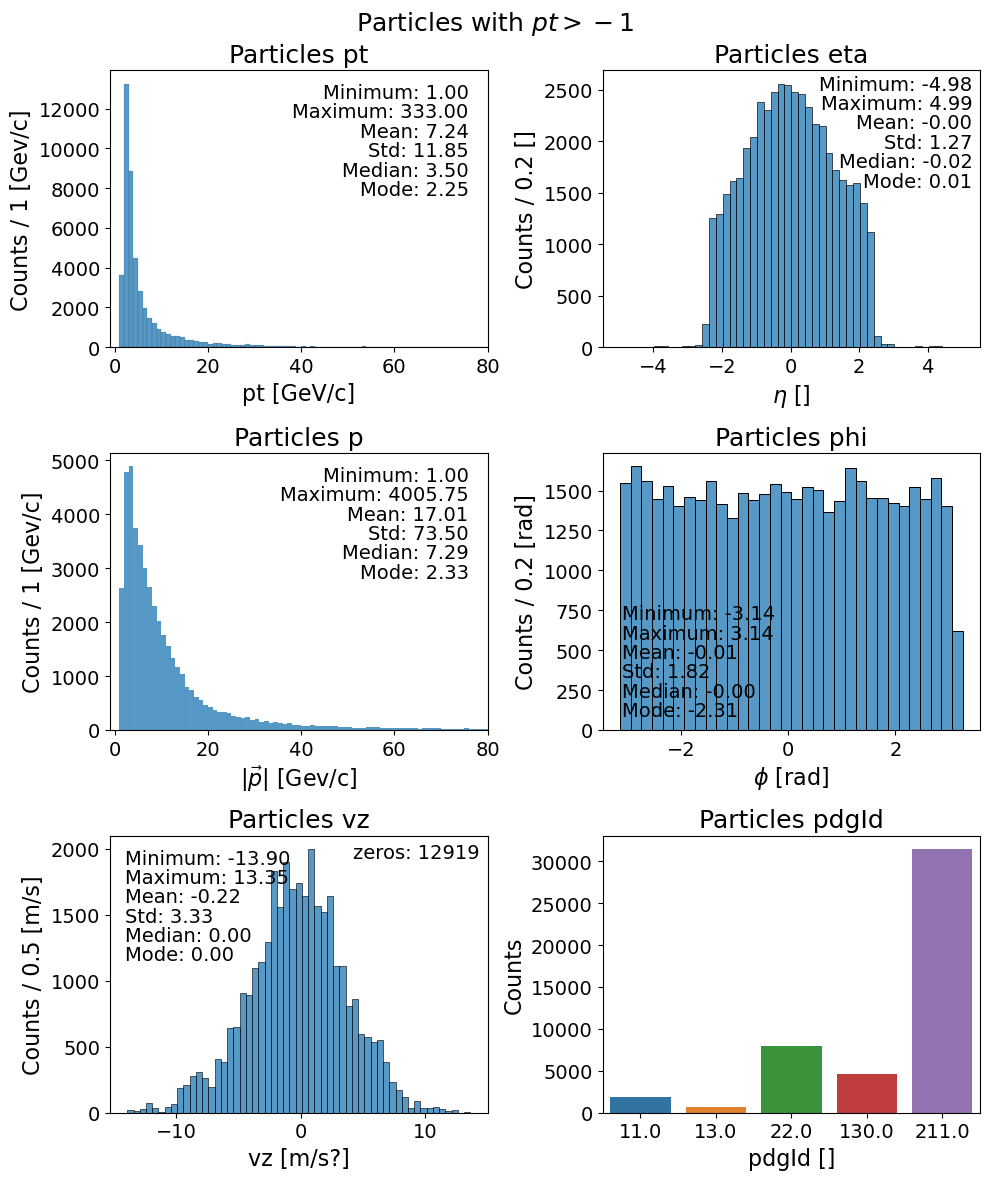

In [86]:

# simple 1D hists of particle quantities
fig, axs = plt.subplots(3, 2, figsize=(10, 12), tight_layout=True)

bw=1
# pt
part_pt_df = data[[particle+'pt' for particle in particle_colnames]].stack().reset_index(level=2, drop=True)

sns.histplot(part_pt_df[part_pt_df>-1.], binwidth=bw, ax=axs[0, 0])
axs[0, 0].set_title('Particles pt', fontsize=FONTSIZE+2)
axs[0, 0].set_xlabel('pt [GeV/c]', fontsize=FONTSIZE)
axs[0, 0].set_ylabel(f'Counts / {bw} [Gev/c]', fontsize=FONTSIZE)
axs[0, 0].tick_params(labelsize=FONTSIZE-2)
axs[0, 0].set_xlim(-1, 80)
display_statistics(part_pt_df[part_pt_df>-1.], axs[0, 0], fontsize=FONTSIZE-2, align="right", x=0.95, y=0.9, step=0.07)

# eta
part_eta_df = data[[particle+'eta' for particle in particle_colnames]].stack().reset_index(level=2, drop=True)

sns.histplot(part_eta_df[part_pt_df>-1.], binwidth=.2, ax=axs[0, 1])
axs[0, 1].set_title('Particles eta', fontsize=FONTSIZE+2)
axs[0, 1].set_xlabel(r'$\eta$ []', fontsize=FONTSIZE)
axs[0, 1].set_ylabel('Counts / 0.2 []', fontsize=FONTSIZE)
axs[0, 1].tick_params(labelsize=FONTSIZE-2)
display_statistics(part_eta_df[part_pt_df>-1.], axs[0, 1], fontsize=FONTSIZE-2, align="right", x=0.98, y=0.93, step=0.07)

bw=1
# |p|
part_p_df = part_pt_df*np.cosh(part_eta_df)

sns.histplot(part_p_df[part_pt_df>-1.], binwidth=bw, ax=axs[1, 0])
axs[1, 0].set_title('Particles p', fontsize=FONTSIZE+2)
axs[1, 0].set_xlabel(r'$|\vec{p}|$ [Gev/c]', fontsize=FONTSIZE)
axs[1, 0].set_ylabel(f'Counts / {bw} [Gev/c]', fontsize=FONTSIZE)
axs[1, 0].tick_params(labelsize=FONTSIZE-2)
axs[1, 0].set_xlim(-1, 80)
display_statistics(part_p_df[part_pt_df>-1.], axs[1, 0], fontsize=FONTSIZE-2, align="right", x=0.95, y=0.9, step=0.07)

# phi
part_phi_df = data[[particle+'phi' for particle in particle_colnames]].stack().reset_index(level=2, drop=True)

sns.histplot(part_phi_df[part_pt_df>-1.], binwidth=0.2, ax=axs[1, 1])
axs[1, 1].set_title('Particles phi', fontsize=FONTSIZE+2)
axs[1, 1].set_xlabel(r'$\phi$ [rad]', fontsize=FONTSIZE)
axs[1, 1].set_ylabel('Counts / 0.2 [rad]', fontsize=FONTSIZE)
axs[1, 1].tick_params(labelsize=FONTSIZE-2)
display_statistics(part_phi_df[part_pt_df>-1.], axs[1, 1], fontsize=FONTSIZE-2, align="left", x=0.05, y=0.4, step=0.07)

bw=0.5
# vz
part_vz_df = data[[particle+'vz' for particle in particle_colnames]].stack().reset_index(level=2, drop=True)

sns.histplot(part_vz_df[(part_pt_df>-1.) & (part_vz_df.abs()>0.)], binwidth=bw, ax=axs[2, 0])
axs[2, 0].set_title('Particles vz', fontsize=FONTSIZE+2)
axs[2, 0].set_xlabel('vz [m/s?]', fontsize=FONTSIZE)
axs[2, 0].set_ylabel(f'Counts / {bw} [m/s]', fontsize=FONTSIZE)
axs[2, 0].tick_params(labelsize=FONTSIZE-2)

axs[2, 0].text(0.98, 0.92, f"zeros: {np.sum(~(part_vz_df.abs()>0.))}",  fontsize=FONTSIZE-2, transform=axs[2, 0].transAxes, ha='right')   
display_statistics(part_vz_df[part_pt_df>-1.], axs[2, 0], fontsize=FONTSIZE-2, align="left", x=0.04, y=0.9, step=0.07)

# pdgId
part_pdgId_df = data[[particle+'pdgId' for particle in particle_colnames]].stack().reset_index(level=2, drop=True).abs()

sns.countplot(x=part_pdgId_df[part_pt_df>-1.], ax=axs[2, 1])
axs[2, 1].set_title('Particles pdgId', fontsize=FONTSIZE+2)
axs[2, 1].set_xlabel('pdgId []', fontsize=FONTSIZE)
axs[2, 1].set_ylabel('Counts', fontsize=FONTSIZE)
axs[2, 1].tick_params(labelsize=FONTSIZE-2)

print('#keeped particles/tot: {}/{}'.format(np.sum(part_pt_df>-1.), len(part_pt_df)))

fig.suptitle(r'Particles with $pt >-1$', fontsize=FONTSIZE+2)

In [87]:
fig.savefig(image_dir+'naive_particles.svg')

Text(0.5, 0.98, 'Particles with $pt = -1, i.e.$ no daughters')

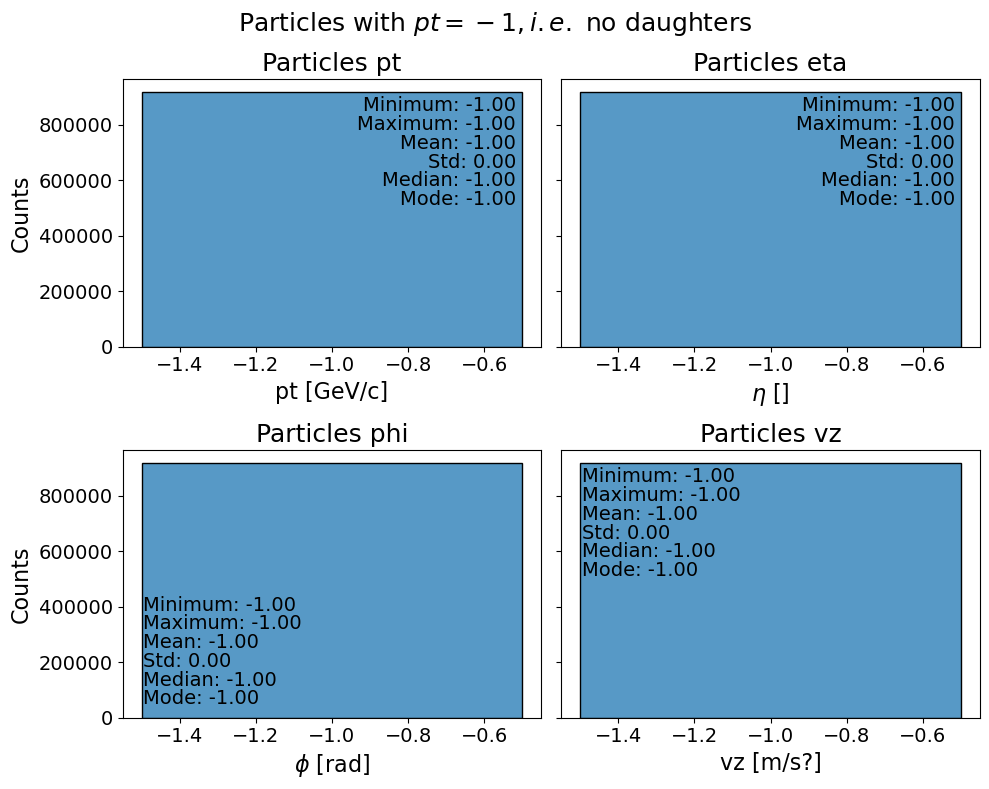

In [84]:

# simple 1D hists of particle quantities, pt = -1
fig, axs = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True, sharey=True)

# pt
sns.histplot(part_pt_df[~ (part_pt_df>-1.)],ax=axs[0, 0])
axs[0, 0].set_title('Particles pt', fontsize=FONTSIZE+2)
axs[0, 0].set_xlabel('pt [GeV/c]', fontsize=FONTSIZE)
axs[0, 0].set_ylabel('Counts', fontsize=FONTSIZE)
axs[0, 0].tick_params(labelsize=FONTSIZE-2)
display_statistics(part_pt_df[~(part_pt_df>-1.)], axs[0, 0], fontsize=FONTSIZE-2, align="right", x=0.94, y=0.88, step=0.07)

# eta
part_eta_df = data[[particle+'eta' for particle in particle_colnames]].stack().reset_index(level=2, drop=True)

sns.histplot(part_eta_df[~(part_pt_df>-1.)], ax=axs[0, 1])
axs[0, 1].set_title('Particles eta', fontsize=FONTSIZE+2)
axs[0, 1].set_xlabel(r'$\eta$ []', fontsize=FONTSIZE)
axs[0, 1].set_ylabel('Counts', fontsize=FONTSIZE)
axs[0, 1].tick_params(labelsize=FONTSIZE-2)
display_statistics(part_eta_df[~(part_pt_df>-1.)], axs[0, 1], fontsize=FONTSIZE-2, align="right", x=0.94, y=0.88, step=0.07)


# phi
part_phi_df = data[[particle+'phi' for particle in particle_colnames]].stack().reset_index(level=2, drop=True)

sns.histplot(part_phi_df[~(part_pt_df>-1.)], ax=axs[1, 0])
axs[1, 0].set_title('Particles phi', fontsize=FONTSIZE+2)
axs[1, 0].set_xlabel(r'$\phi$ [rad]', fontsize=FONTSIZE)
axs[1, 0].set_ylabel('Counts', fontsize=FONTSIZE)
axs[1, 0].tick_params(labelsize=FONTSIZE-2)
display_statistics(part_phi_df[~(part_pt_df>-1.)], axs[1, 0], fontsize=FONTSIZE-2, align="left", x=0.05, y=0.4, step=0.07)

# vz
part_vz_df = data[[particle+'vz' for particle in particle_colnames]].stack().reset_index(level=2, drop=True)

sns.histplot(part_vz_df[~(part_pt_df>-1.)], ax=axs[1, 1])
axs[1, 1].set_title('Particles vz', fontsize=FONTSIZE+2)
axs[1, 1].set_xlabel('vz [m/s?]', fontsize=FONTSIZE)
axs[1, 1].set_ylabel('Counts', fontsize=FONTSIZE)
axs[1, 1].tick_params(labelsize=FONTSIZE-2)
display_statistics(part_vz_df[~(part_pt_df>-1.)], axs[1, 1], fontsize=FONTSIZE-2, align="left", x=0.05, y=0.88, step=0.07)


fig.suptitle(r'Particles with $pt = -1, i.e.$ no daughters', fontsize=FONTSIZE+2)

In [85]:
fig.savefig(image_dir+'pt-1_particles.svg')

__N.B. quantities are set to -1 when the particle has no daughters__

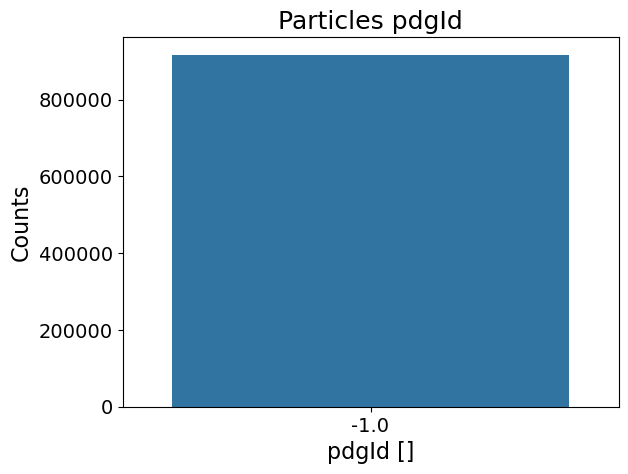

In [27]:
ax = sns.countplot(x=part_pdgId_df[~(part_pt_df>-1.)])
ax.set_title('Particles pdgId', fontsize=FONTSIZE+2)
ax.set_xlabel('pdgId []', fontsize=FONTSIZE)
ax.set_ylabel('Counts', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)

### Energy info
No direct access to energy is present in the dataset, can we calculate it starting from `pt`, `eta` and `vz` ? 

$$
    \begin{gather}
    \eta = \arctan\bigg(\frac{p_L}{|\vec{p}|}\bigg) \\
    \tanh(\eta) = \frac{\sqrt{|\vec{p}|^2+p_T^2}}{|\vec{p}|} \\
    |\vec{p}| = \frac{p_T}{\sqrt{1-\tanh^2(\eta)}} = p_T \cosh(\eta) \\
    p_L = |\vec{p}| |\tanh(\eta)| = p_T |\sinh(\eta)|
    \end{gather}
$$

## Naive jet analysis

Text(0.5, 0.98, 'Jets')

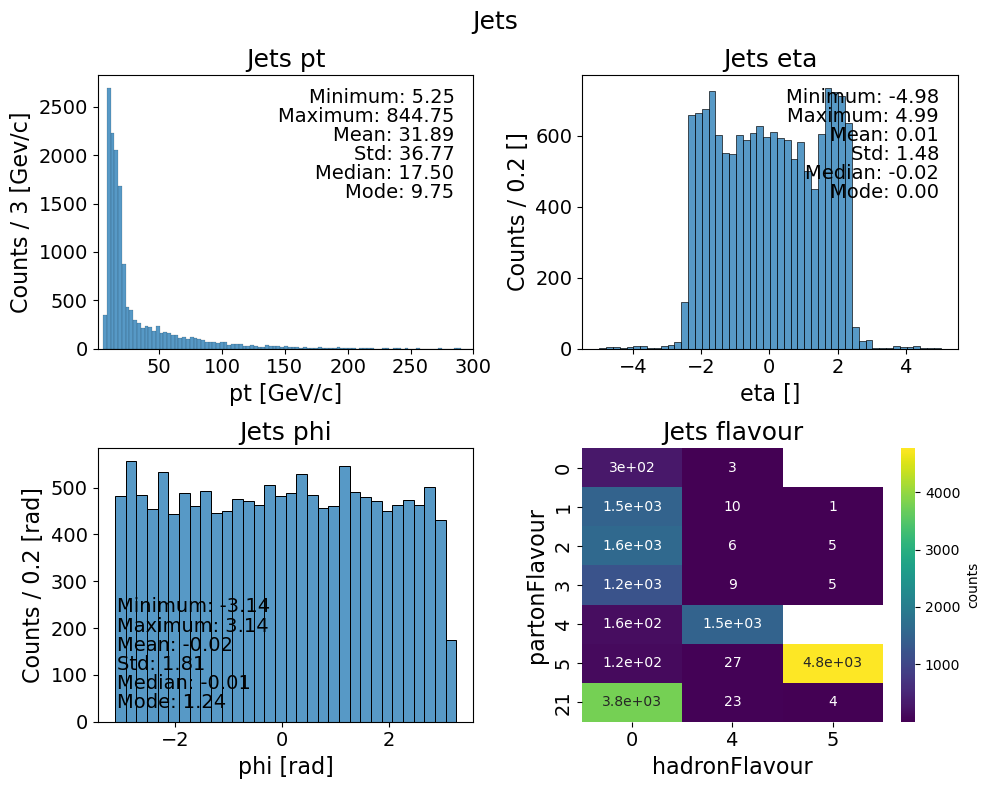

In [88]:
jet_members = ['pt', 'eta', 'phi']
# simple 1D hists of particle quantities
fig, axs = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)

bw=3
# pt
sns.histplot(data['pt'], binwidth=bw, ax=axs[0, 0])
axs[0, 0].set_title('Jets pt', fontsize=FONTSIZE+2)
axs[0, 0].set_xlabel('pt [GeV/c]', fontsize=FONTSIZE)
axs[0, 0].set_ylabel(f'Counts / {bw} [Gev/c]', fontsize=FONTSIZE)
axs[0, 0].tick_params(labelsize=FONTSIZE-2)
axs[0, 0].set_xlim(1, 300)
display_statistics(data['pt'], axs[0, 0], fontsize=FONTSIZE-2, align="right", x=0.95, y=0.9, step=0.07)

# eta
sns.histplot(data['eta'], binwidth=.2, ax=axs[0, 1])
axs[0, 1].set_title('Jets eta', fontsize=FONTSIZE+2)
axs[0, 1].set_xlabel('eta []', fontsize=FONTSIZE)
axs[0, 1].set_ylabel('Counts / 0.2 []', fontsize=FONTSIZE)
axs[0, 1].tick_params(labelsize=FONTSIZE-2)
display_statistics(data['eta'], axs[0, 1], fontsize=FONTSIZE-2, align="right", x=0.95, y=0.9, step=0.07)


# phi
sns.histplot(data['phi'], binwidth=.2, ax=axs[1, 0])
axs[1, 0].set_title('Jets phi', fontsize=FONTSIZE+2)
axs[1, 0].set_xlabel('phi [rad]', fontsize=FONTSIZE)
axs[1, 0].set_ylabel('Counts / 0.2 [rad]', fontsize=FONTSIZE)
axs[1, 0].tick_params(labelsize=FONTSIZE-2)
display_statistics(data['phi'], axs[1, 0], fontsize=FONTSIZE-2, align="left", x=0.05, y=0.4, step=0.07)

# flavour
jets_flavours = geninfo[['hadronFlavour', 'partonFlavour']].abs().groupby(['hadronFlavour', 'partonFlavour'])\
                .size().reset_index(name='counts').pivot(index='partonFlavour', columns='hadronFlavour', values='counts')

sns.heatmap(jets_flavours, cmap='viridis', annot=True, ax = axs[1, 1], cbar_kws={'label':'counts'})
axs[1, 1].set_title('Jets flavour', fontsize=FONTSIZE+2)
axs[1, 1].set_xlabel('hadronFlavour', fontsize=FONTSIZE)
axs[1, 1].set_ylabel('partonFlavour', fontsize=FONTSIZE)
axs[1, 1].tick_params(labelsize=FONTSIZE-2)
#display_statistics(data['pt'], axs[1, 1], fontsize=FONTSIZE-2, align="right", x=0.95, y=0.9, step=0.07)


fig.suptitle('Jets', fontsize=FONTSIZE+2)

In [89]:
fig.savefig(image_dir+'naive_jets.svg')

# Cross analyses

In [48]:
# get same histograms as before but associating a particle to the jet
strip = np.vectorize(lambda x: x[7:])
minR = strip(np.asarray(geninfo.columns.values[np.argmin(geninfo.drop(['min_dR_genjet', 'partonFlavour', 'hadronFlavour'], axis=1), axis=1)], dtype='str'))

crossing_df_minR = data.copy()
crossing_df_minR['minR'] = minR
crossing_df_minR['hadronFlavour'] = geninfo['hadronFlavour'].droplevel(2)
crossing_df_minR['partonFlavour'] = geninfo['partonFlavour'].droplevel(2)

## Cross particle analysis

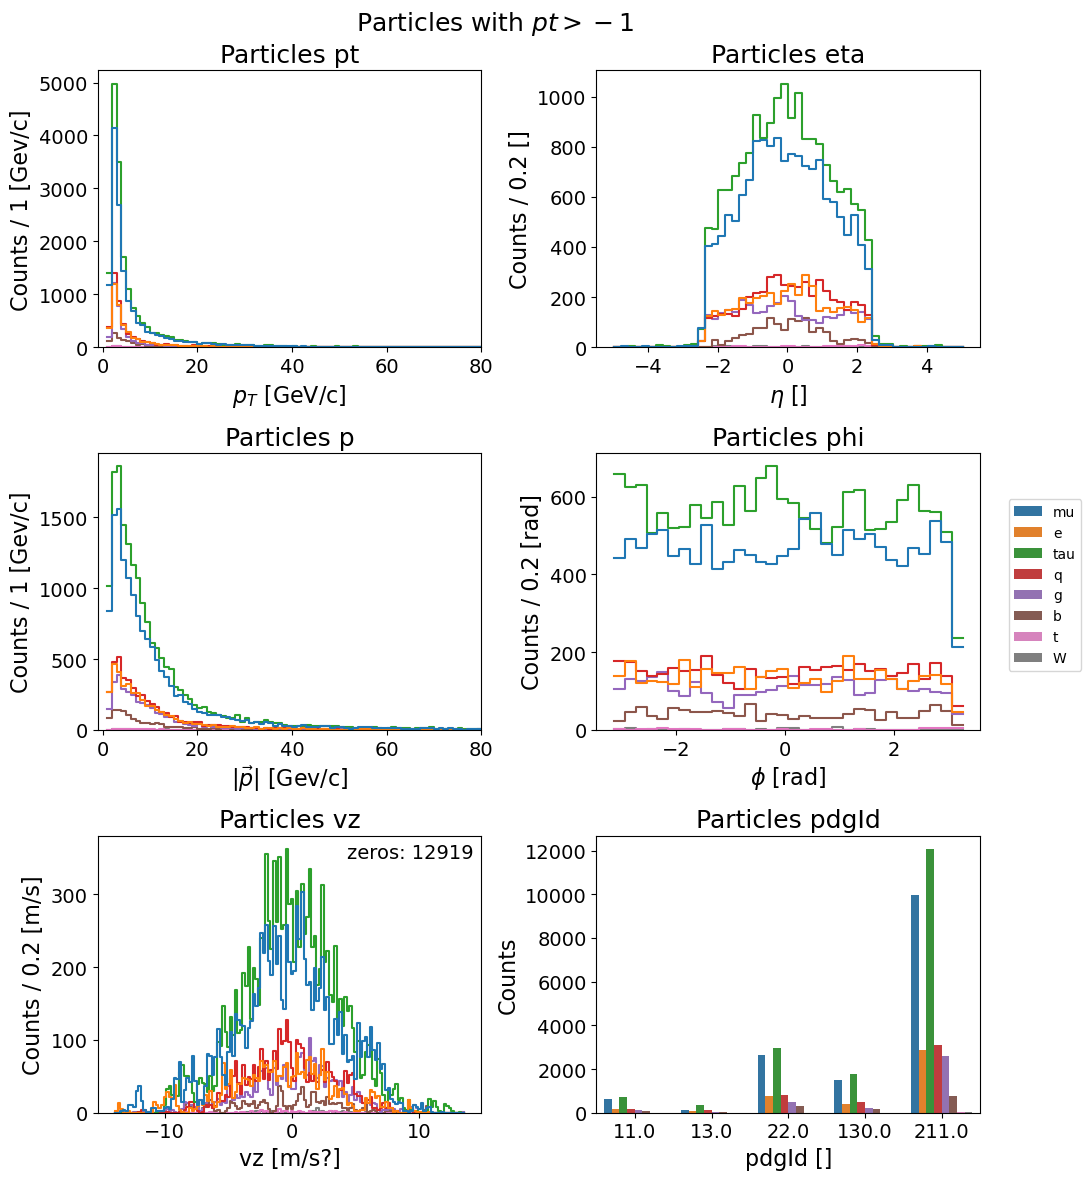

In [90]:

# simple 1D hists of particle quantities
fig, axs = plt.subplots(3, 2, figsize=(10, 12), tight_layout=True)

bw=1
# pt
crosspart_pt_df = crossing_df_minR[[particle+'pt' for particle in particle_colnames]].stack().reset_index(level=2, name='x')
crosspart_pt_df['minR'] = crossing_df_minR['minR']
crosspart_pt_df.drop('level_2', axis=1)

sns.histplot(crosspart_pt_df[part_pt_df>-1.], x='x', binwidth=bw, hue='minR', element='step', fill=False, legend=False, ax=axs[0, 0])
axs[0, 0].set_title('Particles pt', fontsize=FONTSIZE+2)
axs[0, 0].set_xlabel(r'$p_T$ [GeV/c]', fontsize=FONTSIZE)
axs[0, 0].set_ylabel(f'Counts / {bw} [Gev/c]', fontsize=FONTSIZE)
axs[0, 0].tick_params(labelsize=FONTSIZE-2)
axs[0, 0].set_xlim(-1, 80)
#display_statistics(crosspart_pt_df[crosspart_pt_df>-1.], axs[0, 0], fontsize=FONTSIZE-2, align="right", x=0.95, y=0.9, step=0.07)

bw=0.2
# eta
crosspart_eta_df = crossing_df_minR[[particle+'eta' for particle in particle_colnames]].stack().reset_index(level=2, name='x')
crosspart_eta_df['minR'] = crossing_df_minR['minR']
crosspart_eta_df.drop('level_2', axis=1)

sns.histplot(crosspart_eta_df[part_pt_df>-1.], x='x', binwidth=bw, hue='minR', element='step', fill=False, legend=False, ax=axs[0, 1])
axs[0, 1].set_title('Particles eta', fontsize=FONTSIZE+2)
axs[0, 1].set_xlabel(r'$\eta$ []', fontsize=FONTSIZE)
axs[0, 1].set_ylabel(f'Counts / {bw} []', fontsize=FONTSIZE)
axs[0, 1].tick_params(labelsize=FONTSIZE-2)
#display_statistics(crosspart_eta_df[part_pt_df>-1.], axs[0, 1], fontsize=FONTSIZE-2, align="right", x=0.98, y=0.93, step=0.07)

bw=1
# |p|
crosspart_p_df = crosspart_pt_df[['x']]*np.cosh(crosspart_eta_df[['x']])
crosspart_p_df['minR'] = crossing_df_minR['minR']
#crosspart_p_df.drop('level_2', axis=1)

sns.histplot(crosspart_p_df[part_pt_df>-1.], x='x', binwidth=bw, hue='minR', element='step', fill=False, legend=False, ax=axs[1, 0])
axs[1, 0].set_title('Particles p', fontsize=FONTSIZE+2)
axs[1, 0].set_xlabel(r'$|\vec{p}|$ [Gev/c]', fontsize=FONTSIZE)
axs[1, 0].set_ylabel(f'Counts / {bw} [Gev/c]', fontsize=FONTSIZE)
axs[1, 0].tick_params(labelsize=FONTSIZE-2)
axs[1, 0].set_xlim(-1, 80)
#display_statistics(crosspart_p_df[part_pt_df>-1.], axs[1, 0], fontsize=FONTSIZE-2, align="right", x=0.95, y=0.9, step=0.07)

bw=0.2
# phi
crosspart_phi_df = crossing_df_minR[[particle+'phi' for particle in particle_colnames]].stack().reset_index(level=2, name='x')
crosspart_phi_df['minR'] = crossing_df_minR['minR']
crosspart_phi_df.drop('level_2', axis=1)

sns.histplot(crosspart_phi_df[part_pt_df>-1.], x='x', binwidth=bw, hue='minR', element='step', fill=False, legend=False, ax=axs[1, 1])
axs[1, 1].set_title('Particles phi', fontsize=FONTSIZE+2)
axs[1, 1].set_xlabel(r'$\phi$ [rad]', fontsize=FONTSIZE)
axs[1, 1].set_ylabel(f'Counts / {bw} [rad]', fontsize=FONTSIZE)
axs[1, 1].tick_params(labelsize=FONTSIZE-2)
#display_statistics(crosspart_phi_df[part_pt_df>-1.], axs[1, 1], fontsize=FONTSIZE-2, align="left", x=0.05, y=0.4, step=0.07)

bw=0.2
# vz
crosspart_vz_df = crossing_df_minR[[particle+'vz' for particle in particle_colnames]].stack().reset_index(level=2, name='x')
crosspart_vz_df['minR'] = crossing_df_minR['minR']
crosspart_vz_df.drop('level_2', axis=1)

sns.histplot(crosspart_vz_df[(part_pt_df>-1.) & (crosspart_vz_df['x'].abs()>0.)], x='x', binwidth=bw, hue='minR', element='step', fill=False, legend=False, ax=axs[2, 0])
axs[2, 0].set_title('Particles vz', fontsize=FONTSIZE+2)
axs[2, 0].set_xlabel('vz [m/s?]', fontsize=FONTSIZE)
axs[2, 0].set_ylabel(f'Counts / {bw} [m/s]', fontsize=FONTSIZE)
axs[2, 0].tick_params(labelsize=FONTSIZE-2)

axs[2, 0].text(0.98, 0.92, f"zeros: {np.sum(~(crosspart_vz_df['x'].abs()>0.))}",  fontsize=FONTSIZE-2, transform=axs[2, 0].transAxes, ha='right')   
#display_statistics(crosspart_vz_df[part_pt_df>-1.], axs[2, 0], fontsize=FONTSIZE-2, align="left", x=0.04, y=0.9, step=0.07)

# pdgId
crosspart_pdgId_df = crossing_df_minR[[particle+'pdgId' for particle in particle_colnames]].stack().reset_index(level=2, name='x')
crosspart_pdgId_df['x']=crosspart_pdgId_df['x'].abs()
crosspart_pdgId_df['minR'] = crossing_df_minR['minR']
crosspart_pdgId_df.drop('level_2', axis=1)

sns.countplot(crosspart_pdgId_df[part_pt_df>-1.], x='x', hue='minR', ax=axs[2, 1])
axs[2, 1].set_title('Particles pdgId', fontsize=FONTSIZE+2)
axs[2, 1].set_xlabel('pdgId []', fontsize=FONTSIZE)
axs[2, 1].set_ylabel('Counts', fontsize=FONTSIZE)
axs[2, 1].tick_params(labelsize=FONTSIZE-2)
handles, labels = axs[2, 1].get_legend_handles_labels()
axs[2, 1].legend([], [], frameon=False)


fig.suptitle(r'Particles with $pt >-1$', fontsize=FONTSIZE+2)
fig.legend(handles, labels, loc='center', bbox_to_anchor=(1.05, 0.5))

In [91]:
fig.savefig(image_dir+'cross_particles.svg')

## Jet cross analysis

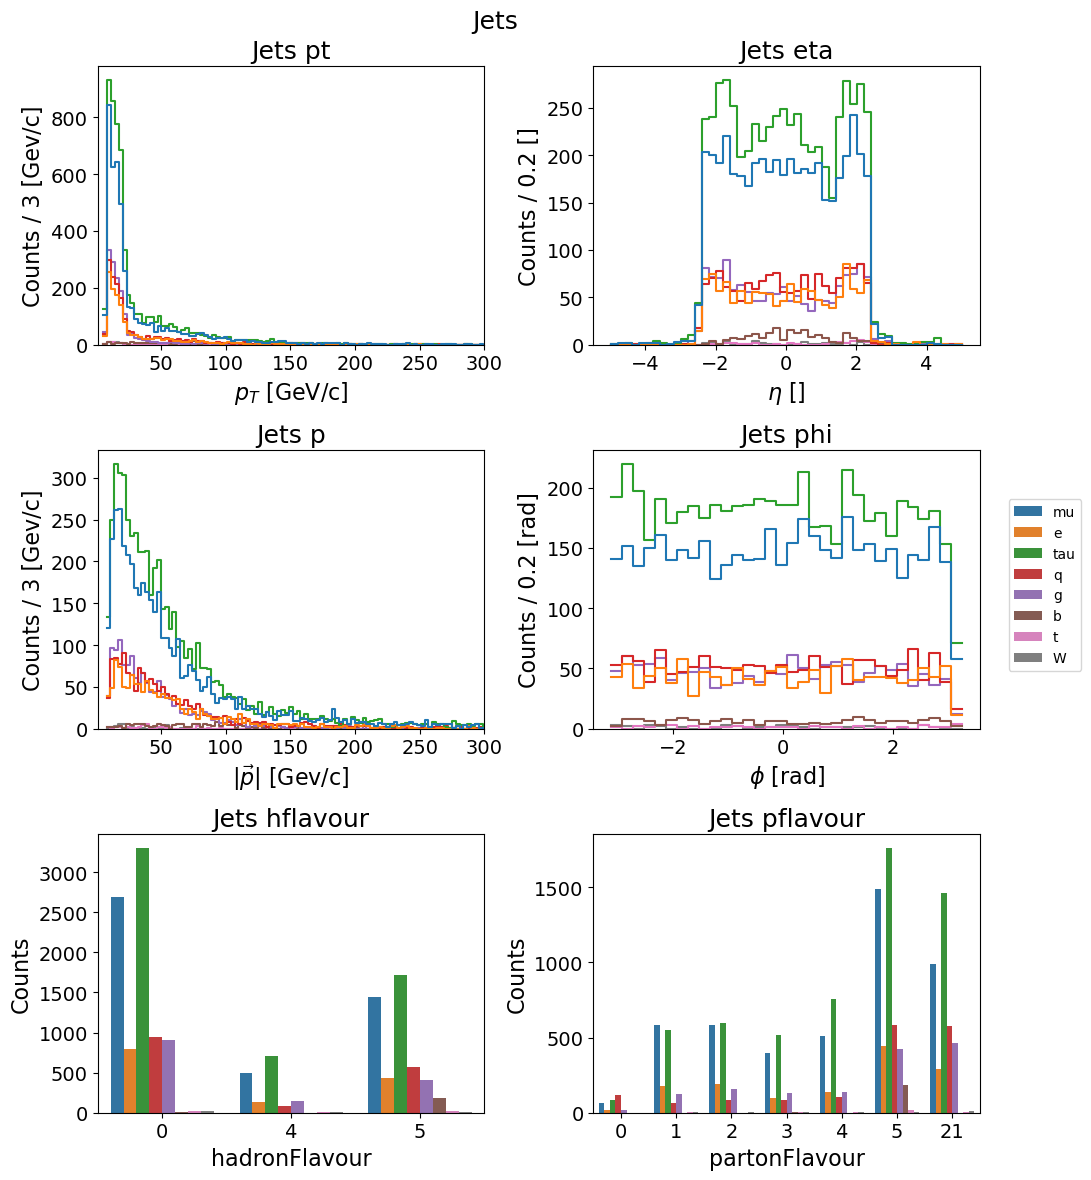

In [92]:
jet_members = ['pt', 'eta', 'phi']
# simple 1D hists of particle quantities
fig, axs = plt.subplots(3, 2, figsize=(10, 12), tight_layout=True)

bw=3
# pt
sns.histplot(crossing_df_minR, x='pt', binwidth=bw, hue='minR', element='step', fill=False, ax=axs[0, 0], legend=False)
axs[0, 0].set_title('Jets pt', fontsize=FONTSIZE+2)
axs[0, 0].set_xlabel(r'$p_T$ [GeV/c]', fontsize=FONTSIZE)
axs[0, 0].set_ylabel(f'Counts / {bw} [Gev/c]', fontsize=FONTSIZE)
axs[0, 0].tick_params(labelsize=FONTSIZE-2)
axs[0, 0].set_xlim(1, 300)
#display_statistics(crossing_df_minR['pt'], axs[0, 0], fontsize=FONTSIZE-2, align="right", x=0.95, y=0.9, step=0.07)

# eta
bw=0.2
sns.histplot(crossing_df_minR, x='eta', binwidth=bw, hue='minR', element='step', fill=False, ax=axs[0, 1], legend=False)
axs[0, 1].set_title('Jets eta', fontsize=FONTSIZE+2)
axs[0, 1].set_xlabel(r'$\eta$ []', fontsize=FONTSIZE)
axs[0, 1].set_ylabel(f'Counts / {bw} []', fontsize=FONTSIZE)
axs[0, 1].tick_params(labelsize=FONTSIZE-2)
#display_statistics(crossing_df_minR['eta'], axs[0, 1], fontsize=FONTSIZE-2, align="right", x=0.95, y=0.9, step=0.07)

# |p|
bw=3
sns.histplot(crossing_df_minR, x=crossing_df_minR['pt']*np.cosh(crossing_df_minR['eta']), binwidth=bw, hue='minR', element='step', fill=False, ax=axs[1, 0], legend=False)
axs[1, 0].set_title('Jets p', fontsize=FONTSIZE+2)
axs[1, 0].set_xlabel(r'$|\vec{p}|$ [Gev/c]', fontsize=FONTSIZE)
axs[1, 0].set_ylabel(f'Counts / {bw} [Gev/c]', fontsize=FONTSIZE)
axs[1, 0].tick_params(labelsize=FONTSIZE-2)
axs[1, 0].set_xlim(1, 300)

# phi
bw=0.2
sns.histplot(crossing_df_minR, x='phi', binwidth=bw, hue='minR', element='step', fill=False, ax=axs[1, 1], legend=False)
axs[1, 1].set_title('Jets phi', fontsize=FONTSIZE+2)
axs[1, 1].set_xlabel(r'$\phi$ [rad]', fontsize=FONTSIZE)
axs[1, 1].set_ylabel(f'Counts / {bw} [rad]', fontsize=FONTSIZE)
axs[1, 1].tick_params(labelsize=FONTSIZE-2)
#display_statistics(crossing_df_minR['phi'], axs[1, 0], fontsize=FONTSIZE-2, align="left", x=0.05, y=0.4, step=0.07)

# flavour
#crossing_flavours = geninfo[['hadronFlavour', 'partonFlavour']].abs().groupby(['hadronFlavour', 'partonFlavour'])\
#                .size().reset_index(name='counts').pivot(index='partonFlavour', columns='hadronFlavour', values='counts')

sns.countplot(crossing_df_minR, x='hadronFlavour', hue='minR', ax = axs[2, 0])
axs[2, 0].set_title('Jets hflavour', fontsize=FONTSIZE+2)
axs[2, 0].set_xlabel('hadronFlavour', fontsize=FONTSIZE)
axs[2, 0].set_ylabel('Counts', fontsize=FONTSIZE)
axs[2, 0].tick_params(labelsize=FONTSIZE-2)
axs[2, 0].legend([], [], frameon=False)
#display_statistics(crossing_df_minR['pt'], axs[1, 1], fontsize=FONTSIZE-2, align="right", x=0.95, y=0.9, step=0.07)

sns.countplot(crossing_df_minR, x=crossing_df_minR['partonFlavour'].abs(), hue='minR', ax = axs[2, 1])
axs[2, 1].set_title('Jets pflavour', fontsize=FONTSIZE+2)
axs[2, 1].set_xlabel('partonFlavour', fontsize=FONTSIZE)
axs[2, 1].set_ylabel('Counts', fontsize=FONTSIZE)
axs[2, 1].tick_params(labelsize=FONTSIZE-2)
handles, labels = axs[2, 1].get_legend_handles_labels()
axs[2, 1].legend([], [], frameon=False)

fig.suptitle('Jets', fontsize=FONTSIZE+2)
fig.legend(handles, labels, loc='center', bbox_to_anchor=(1.05, 0.5))

In [93]:
fig.savefig(image_dir+'cross_jets.svg')